# Imports

In [32]:
# System Imports
import os
import time

# Data Imports
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import scipy as sp
import cv2

import helper_functions as hf

# Deep Learning Framework
import tensorflow as tf

# SSL
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

## Reading in Images

In [33]:
# Setting paths

train_data_path = './data/archive/train'
test_data_path = './data/archive/test'

In [34]:
# Viewing the classes

categories = os.listdir(train_data_path)
print(f"The classes are: {categories}")

The classes are: ['daisy', 'rose', 'tulip', 'dandelion', 'sunflower']


In [35]:
# Configurations

SEED = 0
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.20
EPOCHS = 10

In [36]:
# Creating the training set

training_set = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_path,
    validation_split=VALIDATION_SPLIT,
    subset="training",
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    class_names=categories
)

Found 2746 files belonging to 5 classes.
Using 2197 files for training.


In [37]:
# Creating the validation set

validation_set = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_path,
    validation_split=VALIDATION_SPLIT,
    subset="validation",
    seed=SEED,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    class_names=categories
)

Found 2746 files belonging to 5 classes.
Using 549 files for validation.


## Plotting Images

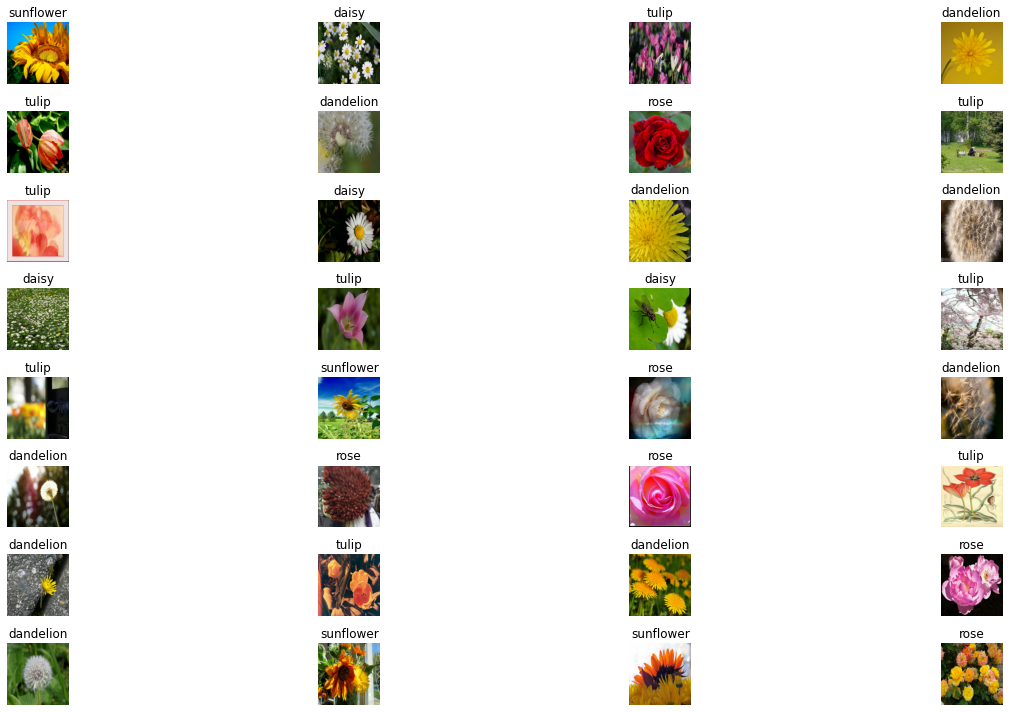

In [38]:
# Plotting some images

hf.plot_images(training_set, categories)

# Modeling

In [39]:
# Function that creates a model

def get_baseline_model(): 

    ## Clearing backend
    tf.keras.backend.clear_session()

    ## Input Layer
    inputs = tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

    # Rescaling the images
    x = tf.keras.layers.Rescaling(1./255)(inputs)

    ## First CNN
    x = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=(3,3),
        strides=(1,1),
        activation='relu',
    )(x)

    x = tf.keras.layers.MaxPool2D(
        pool_size=(2, 2)
    )(x)

    ## Second CNN
    x = tf.keras.layers.Conv2D(
        filters=64,
        kernel_size=(3,3),
        strides=(1,1),
        activation='relu',
    )(x)

    x = tf.keras.layers.MaxPool2D(
        pool_size=(2, 2)
    )(x)

    ## Third CNN
    x = tf.keras.layers.Conv2D(
        filters=128,
        kernel_size=(3,3),
        strides=(1,1),
        activation='relu',
    )(x)

    x = tf.keras.layers.MaxPool2D(
        pool_size=(2, 2)
    )(x)

    ## Flatten layer
    x = tf.keras.layers.Flatten()(x)

    ## First Dense layer
    x = tf.keras.layers.Dense(
        units=64,
        activation='relu'
    )(x)

    ## Output
    outputs = tf.keras.layers.Dense(
        units=len(categories),
        activation='softmax'
    )(x)

    ## Creating Model
    model = tf.keras.Model(
        inputs=inputs,
        outputs=outputs
    )

    ## Compiling the model
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=['accuracy']
    )

    ## Viewing the architecture
    model.summary()

    return model

In [40]:
model_elapsed_time = {}

In [41]:
# # Training the model

# start_time = time.time()

# baseline_model = get_baseline_model()

# history = baseline_model.fit(
#   training_set,
#   validation_data=validation_set,
#   epochs=EPOCHS
# )

# elasped_time = time.time() - start_time
# model_elapsed_time["baseline"] = elasped_time

In [42]:
# # Viewing the results of the training

# hf.plot_history(history)

In [43]:
# hf.plot_actual_prediction(baseline_model, categories, validation_set)

Model is not performing well. Accuracy is terrible (bias is high). And generalization is bad (variance is high). 

Since the model did not accurately predict the flowers, the model didn't learn key features that differentiates the flowers (categories).

Solutions:
<ul>
    <li> Data Augmentation </li>
         * Create new images by augmenting the images to expose the model to more images
    <li> Transfer Learning</li>
        * Use a working model that performs well for our task<br>
    <li> Get more data</li>
        * Find more data for the model
</ul>

## Data Augmentation

In [44]:
AUTOTUNE = tf.data.AUTOTUNE

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip(
      "horizontal_and_vertical", 
      input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[0], 3)
  ),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2)
])

def prepare(ds, shuffle=False, augment=False):

    if shuffle:
        ds = ds.shuffle(1000)

    # Use data augmentation only on the training set.
    if augment:
        ds = ds.map(
            lambda x, y: (data_augmentation(x, training=True), y), 
            num_parallel_calls=AUTOTUNE
        )

    # Use buffered prefetching on all datasets.
    return ds.prefetch(buffer_size=AUTOTUNE)

In [45]:
train_ds = prepare(training_set, shuffle=True, augment=True)
val_ds = prepare(validation_set)

In [46]:
# # Running the model

# tf.keras.backend.clear_session()

# start_time = time.time()

# augment_model = get_baseline_model()

# augment_history = augment_model.fit(
#     train_ds,
#     validation_data = val_ds,
#     epochs=EPOCHS
# )

# elasped_time = time.time() - start_time
# model_elapsed_time['data_augmentation'] = elasped_time

In [47]:
# # Viewing the results of the training

# hf.plot_history(augment_history)

In [48]:
# augment_model.save('saved_model/augment_model.h5')

The training and validation have similar accuracy and loss (low variance). However the accuracy is ~70% (high bias). If we would like, we can do more augmentation like random contrasting.

Next we will try transfer learning. Use a model that has a great track record classifying and apply it to our task.

## Transfer Learning

In [49]:
base_transfer_model = tf.keras.applications.MobileNetV3Small(
    input_shape=IMAGE_SIZE+ (3,),
    include_top=False,
    weights='imagenet',
)

base_transfer_model.trainable = False

base_transfer_model.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                                   

In [50]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_transfer_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 576)


In [51]:
tf.keras.backend.clear_session()
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_transfer_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(len(categories), activation='softmax')(x)
transfer_model = tf.keras.Model(inputs, outputs)

In [52]:
start_time = time.time()

transfer_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

elasped_time = time.time() - start_time
model_elapsed_time['transfer_model'] = elasped_time

In [53]:
transfer_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 576)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 5)                 2885      
                                                                 
Total params: 942,005
Trainable params: 2,885
Non-trainable params: 939,120
_________________________________________________________________


In [54]:
transfer_history = transfer_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=EPOCHS
)

Epoch 1/10
69/69 [==============================] - 18s 205ms/step - loss: 1.1032 - accuracy: 0.5772 - val_loss: 0.7383 - val_accuracy: 0.7359
Epoch 2/10
69/69 [==============================] - 15s 200ms/step - loss: 0.6798 - accuracy: 0.7629 - val_loss: 0.5719 - val_accuracy: 0.8197
Epoch 3/10
69/69 [==============================] - 15s 199ms/step - loss: 0.5597 - accuracy: 0.8088 - val_loss: 0.5020 - val_accuracy: 0.8397
Epoch 4/10
69/69 [==============================] - 16s 203ms/step - loss: 0.4969 - accuracy: 0.8266 - val_loss: 0.4733 - val_accuracy: 0.8506
Epoch 5/10
69/69 [==============================] - 15s 198ms/step - loss: 0.4637 - accuracy: 0.8421 - val_loss: 0.4518 - val_accuracy: 0.8579
Epoch 6/10
69/69 [==============================] - 15s 199ms/step - loss: 0.4275 - accuracy: 0.8512 - val_loss: 0.4257 - val_accuracy: 0.8652
Epoch 7/10
69/69 [==============================] - 17s 220ms/step - loss: 0.4005 - accuracy: 0.8616 - val_loss: 0.4220 - val_accuracy: 0.8707

In [55]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_transfer_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 200

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_transfer_model.layers[fine_tune_at:]:
  layer.trainable = True

Number of layers in the base model:  229


In [56]:
transfer_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

transfer_fine = transfer_model.fit(
    train_ds,
    epochs=EPOCHS+10,
    initial_epoch=transfer_history.epoch[-1],
    validation_data=val_ds
)

Epoch 10/20
69/69 [==============================] - 19s 221ms/step - loss: 0.3663 - accuracy: 0.8707 - val_loss: 0.3891 - val_accuracy: 0.8743
Epoch 11/20
69/69 [==============================] - 17s 223ms/step - loss: 0.3493 - accuracy: 0.8744 - val_loss: 0.3905 - val_accuracy: 0.8707
Epoch 12/20
69/69 [==============================] - 16s 204ms/step - loss: 0.3466 - accuracy: 0.8703 - val_loss: 0.3797 - val_accuracy: 0.8689
Epoch 13/20
69/69 [==============================] - 17s 217ms/step - loss: 0.3254 - accuracy: 0.8862 - val_loss: 0.3798 - val_accuracy: 0.8707
Epoch 14/20
69/69 [==============================] - 16s 206ms/step - loss: 0.3141 - accuracy: 0.8867 - val_loss: 0.3850 - val_accuracy: 0.8689
Epoch 15/20
69/69 [==============================] - 16s 209ms/step - loss: 0.3043 - accuracy: 0.8912 - val_loss: 0.3878 - val_accuracy: 0.8743
Epoch 16/20
69/69 [==============================] - 16s 211ms/step - loss: 0.3130 - accuracy: 0.8908 - val_loss: 0.4140 - val_accuracy:

In [31]:
# hf.plot_history(transfer_fine)

In [ ]:
transfer_model.save('saved_model/transfer_model.h5')

In [52]:
# from tenkeras.models import load_model
loaded_model = tf.keras.models.load_model("./saved_model/transfer_model.h5")

In [59]:
from PIL import Image

new_image_path = './data/FREEDOM.jpg'
image = Image.open(new_image_path).resize((224,224))

In [72]:
arr = np.expand_dims(tf.keras.preprocessing.image.img_to_array(image), axis=0)

In [75]:
pred = loaded_model.predict(arr)

1/1 [==============================] - 0s 33ms/step


In [76]:
np.argmax(pred, axis=1)

array([1])